# Problem Set 4, Part 2: Pose Estimation with Faster-RCNN

Our goal in this part of the assignment is to locate the CheezIt box and estimate its pose. 
- We will run FasterRCNN to detect the object's location. 
- We will use the detection to crop the point cloud to get the points corresponding to the object.
- We will run ICP to estimate the final pose of the object. 

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import os

import meshcat
import meshcat.geometry as g

from pydrake.math import RigidTransform, RotationMatrix, RollPitchYaw
import torch
import cv2

from helper_fns.point_cloud_processing import (VisualizeTransformedScenePointCloud,
                                    make_meshcat_color_array,
                                    GetBoxScenePointCloud, X_WBox)
from helper_fns.vis_utils import draw_square_on_im
from helper_fns.iterative_point_cloud import icp, repeat_icp_until_good_fit
from helper_fns.ransac import VoxelSubsample

RES_DIR = './resources'
#point cloud files
POS_FILE = os.path.join(RES_DIR, 'position_clean.npy')
COL_FILE = os.path.join(RES_DIR, 'color_clean.npy')
#RGB Image file
IMG_FILE = os.path.join(RES_DIR, 'clean_Color.png')
#Pre-computed detections
DET_FILE = os.path.join(RES_DIR, 'clean_Color_det.pkl')

In [2]:
# First start meshcat for visualization - this only has to be run once.

# If you interrupt the kernel of this notebook, you'll need to run this cell again to 
# restart the meshcat server, and then refresh the visualization window. 

# This will open a mesh-cat server in the background, click on the url to display visualization in a separate window. 
vis = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
# Clear visualizer.
vis.delete()

In [4]:
# Lets visualize the current point cloud with color
box_position_point_cloud_scene = np.load(POS_FILE).T
box_color_point_cloud_scene = np.load(COL_FILE).T / 255.
print(box_color_point_cloud_scene.shape)
vis["scene_point_cloud"].set_object(
    g.PointCloud(position=box_position_point_cloud_scene.T,
                 color=make_meshcat_color_array(box_color_point_cloud_scene.shape[0], 
                                                box_color_point_cloud_scene[:, 0], 
                                                box_color_point_cloud_scene[:, 1],
                                                box_color_point_cloud_scene[:, 2]),
                 size=0.002))

(349693, 3)


## 1. FasterRCNN
We will use FasterRCNN to find the bounding box of the CheezIt Box. You'll see that the neural network hallucinates all kinds of objects inside the image. We will use the book detector to find the box.

In [5]:
import torchvision

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

In [6]:
#Read the image into torch
im = plt.imread(IMG_FILE)


print(np.shape(im))
#note we have flipped x, y axis over here
im = np.array(np.transpose(im, (1, 0, 2))[:, ::-1])
im = cv2.resize(im, (480, 848))
image_tensor = torch.from_numpy(im).permute(2, 0, 1).unsqueeze(0).float()
print(image_tensor.size(), image_tensor.max())

(720, 1280, 3)
torch.Size([1, 3, 848, 480]) tensor(1.)


In [7]:
#Compute object detections
out = model(image_tensor)
#In case your computer is unable to run FasterRCNN, please use the following code to load the precomputed boxes.
#import pickle
#with open(DET_FILE, 'rb') as fid:
#    out = pickle.load(fid)

(848, 480, 3)


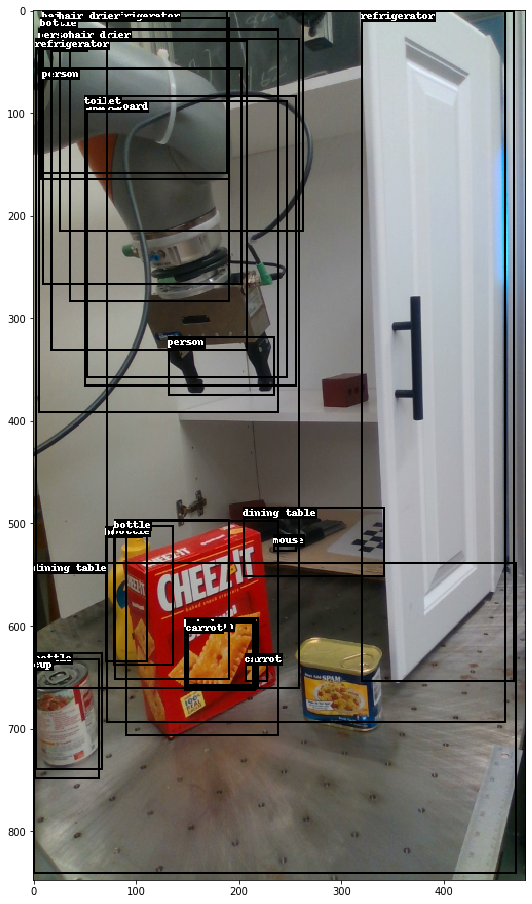

In [8]:
#Visualize the detections
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

import cv2
plt.figure(figsize=(16, 16))
canvas = (255 * im).astype(np.uint8)

print(np.shape(canvas))

for bbox, lbl in zip(out[0]['boxes'], out[0]['labels']):
    b = bbox.detach().cpu().numpy()
    x, y, h, w = b.astype(int)
    conf = COCO_INSTANCE_CATEGORY_NAMES[int(lbl)]
    canvas = draw_square_on_im(canvas, (x, y, h, w), conf=COCO_INSTANCE_CATEGORY_NAMES[int(lbl)], fontsize=100)
plt.imshow(canvas)
plt.show()

In [9]:
# We will use the book detector to find the box
book_idx = np.argwhere(out[0]['labels'] == 84).squeeze().item()
cheezit_bbox = out[0]['boxes'][book_idx].detach().cpu().numpy()
print("bounding box of the cheezeit box, in pixels:\n", cheezit_bbox)

bounding box of the cheezeit box, in pixels:
 [ 90.26529 497.10477 239.2589  707.4288 ]


## 2. Segmenting point cloud using the bounding box from faster RCNN.
Faster RCNN detects the box in the RGB image. In order to segment the corresponding points from the point cloud, we need to perform the following operations: 

1. Get the camera extrinsics and intrinsic matrix.
2. Use this matrix to project the 3D point cloud into a depth image. 
3. Use the 2D detection in the RGB image, to find the corresponding detection in the depth image. 
4. Index back to the 3D points corresponding to the detected location in the depth image. 

The estrinsics and instrinsics of a camera are needed to convert a depth image into/from a point cloud. The extrinsics is simply a uniform transformation of the camera frame's pose relative to world frame. The [intrinsics](http://ksimek.github.io/2013/08/13/intrinsic/) describes how the 3D world outside a camera is projected onto the camera's 2D image sensor. 

**Your first task** is to compelete `calc_intrinsics` and `calc_extrinsics` in `camera_utilities.py`.

In [10]:
from camera_utilities import calc_intrinsics, calc_extrinsics

#camera intrinsics and extrinsics
K = calc_intrinsics()
X_WC = calc_extrinsics()

# Ground truth values
K_value = np.array([[635.491,   0.   , 431.021],
                   [  0.   , 635.491, 238.404],
                   [  0.   ,   0.   ,   1.   ]])

X_WC_value = np.array([[-0.22925465, -0.42440663,  0.87596879, -0.215     ],
                       [-0.0333815 ,  0.90283601,  0.42868733, -0.45      ],
                       [-0.9727939 ,  0.06903741, -0.22114669,  0.425     ],
                       [ 0.        ,  0.        ,  0.        ,  1.        ]])

print("intrinsics error\n", np.max(np.abs(K - K_value)))
print("extrinsics error\n", np.max(np.abs(X_WC.matrix() - X_WC_value)))

intrinsics error
 0.0
extrinsics error
 4.913461415512188e-09


If the intrinsics and extrinsics are correct, the cell below shows the depth image generated from the point cloud currently shown in meshcat. **You need to write two lines of code to flip the depth image into the same frame as the RGB image**. Relevant frames are illustrated in the figure below.

<p align="center" style="text-align: center">
   $C$ is the camera frame. The green plane represents the image sensor, whose center is $f$ away from the origin of frame $C$. The image sensor is 848 pixels long in the x-direction, and 480 pixels long in the y direction. $K$ is the 2D image frame after applying the intrinsics matrix to the points in frame $C$. $I$ is the image frame of the RGB image. <img src="./resources/camera_frames.png" width="400">
   

If you did it correctly, the depth image should look like this:
<p align="center" style="text-align: center">
   Depth image. <img src="./resources/example_depth_image.png" width="250">


ptsW
349693
ptsC
349693
ptsens
349693
(349693, 2)
canvas range: 0.0 255.0


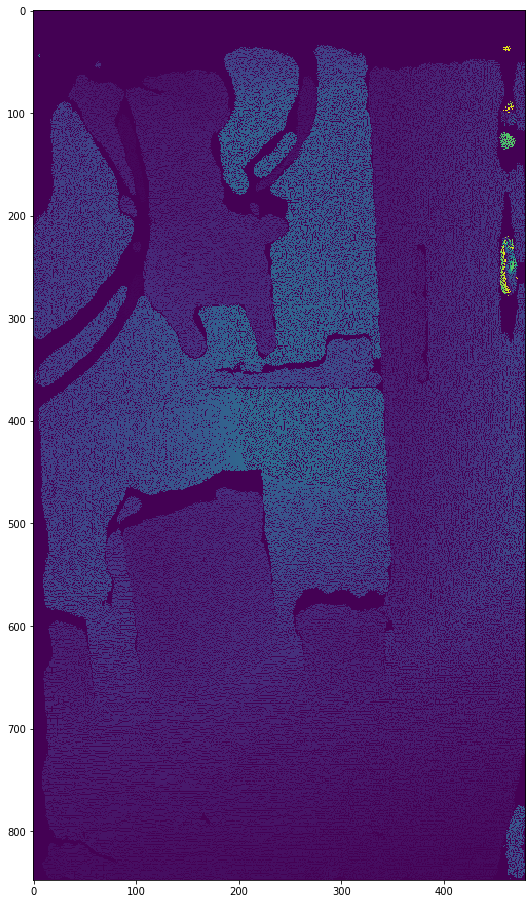

In [11]:
# points in world coordinates
pts_W = box_position_point_cloud_scene # N x 3 world coordinate
print("ptsW")
print(len(pts_W))

# points in camera frame
pts_C = X_WC.inverse().multiply(pts_W.T).T
print("ptsC")
print(len(pts_C))

# apply instrinsics matrix K to points in camera frame.
pts_sensor = (K.dot((pts_C.T / pts_C[:, 2])))[0:2].T

print("ptsens")
print(len(pts_sensor))

# Construct the depth image from points in frame C.
canvas = np.zeros((848, 480))
z_range = 3
z_normalized = (255 * (pts_C[:, 2] - np.min(pts_C[:, 2])) / 3).astype(np.uint8) 
y_manual_clip = 0.5


print(np.shape(pts_sensor))

for i, (x,y) in enumerate(pts_sensor):
    ######## Fill in the Code ###############################
    
    # flipping the image
    #x = (np.shape(canvas)[0]-1) - x
    y = (np.shape(canvas)[1]-1) - y
    
    x_c = int(x)
    y_c = int(y)
    
    canvas[x_c,y_c] = z_normalized[i]
 
    #########################################################
    pass

print('canvas range:', canvas.min(), canvas.max())    
plt.figure(figsize=(16, 16))
plt.imshow(canvas.astype(np.uint8))
plt.show()

Since the depth image is now (almost) in the same coordinate frame as the RGB image, we can transfer the bounding box
from RGB to depth image.

(848, 480, 3)
(848, 480, 3)


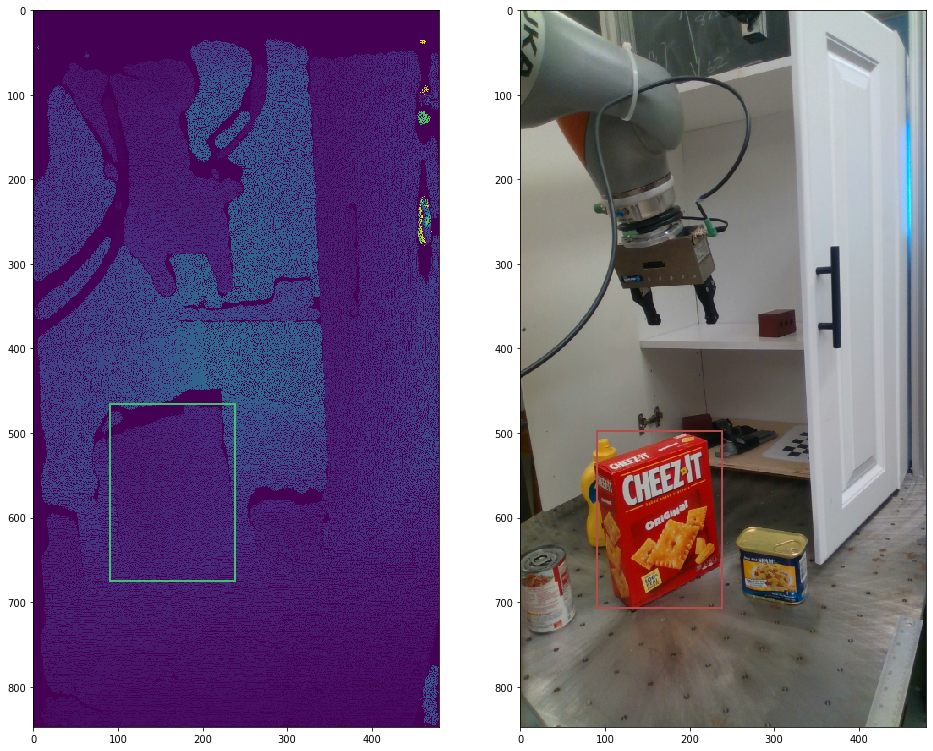

In [12]:
# Let's visualize the detected box location in the depth image.
plt.figure(figsize=(16, 16))
plt.subplot(121)
vis_canvas = canvas.astype(np.uint8)



vis_canvas = np.tile(vis_canvas.reshape(vis_canvas.shape[0], -1, 1), [1, 1, 3])


y1, x1, y2, x2 = cheezit_bbox
dy, dx = 0, -32
vis_canvas = draw_square_on_im(vis_canvas , (y1 + dy, x1 + dx, y2 + dy, x2 + dx), col='red')


plt.imshow(vis_canvas[:, :, 0])

vis_im = draw_square_on_im((255 * im).astype(np.uint8), (y1, x1, y2, x2), col='red')



plt.subplot(122)
plt.imshow(vis_im)
print(np.shape(vis_canvas))
print(np.shape(vis_im))

plt.show()

Now we can filter the points in the point cloud that are within the bounding box determined in the depth image.
- **Complete the for loop to extract the points corresponding to the cheezeit box in the RGB image**. 
- **Include in the PDF a screenshot of the segmented point cloud shown in meshcat, before and after applying the additional heuristics in the next cell**.

(349693, 2)
(848, 480)


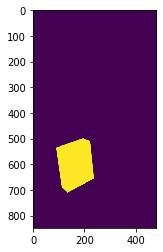

In [48]:
bbox_pos_pts = []
bbox_clr_pts = []

from PIL import Image
#MaskImage
maskImage = Image.open('resources/clean_Color_mask.png');
maskImage = np.asarray(maskImage)




imMsk = np.array(np.transpose(maskImage, (1, 0, 2))[:, ::-1])
imMsk = cv2.resize(imMsk, (480, 848))
imMsk = imMsk[:,:,0]


print(np.shape(pts_sensor))
print(np.shape(imMsk))

plt.imshow(imMsk)
plt.show()




#Filter the points corresponding to the cheezeit box in the point cloud. 
for i, (x,y) in enumerate(pts_sensor):
    ######## Fill in the Code #################################

    # 1.
    # filter only the points in the bounding box
    # larger than x1, smaller than x2
    # larger than y1, smaller than y2
    
    # 2.
    # reconstruct the pixels on the screen to pixels in the real world
    # lets do the flip!
    y = (np.shape(canvas)[1]-1) - y
    
    imMsk[int(x),int(y)]

    
    ''' 
    if (x > x1 and x < x2 and
        y > y1 and y < y2):
    '''
        
                
    if imMsk[int(x),int(y)] > 0:
        
        bbox_pos_pts.append(pts_W[i])
    else:
        bbox_clr_pts.append(pts_W[i])

    
    
    ###########################################################
    pass
            
bbox_pos_pts = np.array(bbox_pos_pts)
bbox_clr_pts = np.array(bbox_clr_pts)



vis["scene_point_cloud"].set_object(
    g.PointCloud(position=bbox_pos_pts.T,
                 color=make_meshcat_color_array(bbox_clr_pts.shape[0], 
                                                bbox_clr_pts[:, 0], 
                                                bbox_clr_pts[:, 1],
                                                bbox_clr_pts[:, 2]),
                 size=0.002))
  

Since we only had a 2D estimate of the box, there are many spurious points in 3D that cannot be filtered. We will use some heuristics to remove them. If a 3D bounding box / 6 DOF pose estimate of the objects is predicted (which DOPE does), such heuristics would not be needed. 

In [46]:
vis.delete()

valid_pts = np.argwhere(bbox_pos_pts[:, 2] > -0.015).squeeze()
bbox_pos_pts = bbox_pos_pts[valid_pts]
bbox_clr_pts = bbox_clr_pts[valid_pts]


valid_pts = np.argwhere(bbox_pos_pts[:, 0] < 0.5).squeeze()
bbox_pos_pts = bbox_pos_pts[valid_pts]
bbox_clr_pts = bbox_clr_pts[valid_pts]


valid_pts = np.argwhere(bbox_pos_pts[:, 1] < 0.01).squeeze()
bbox_pos_pts = bbox_pos_pts[valid_pts]
bbox_clr_pts = bbox_clr_pts[valid_pts]



vis["scene_point_cloud"].set_object(
    g.PointCloud(position=bbox_pos_pts.T,
                 color=make_meshcat_color_array(bbox_clr_pts.shape[0], 
                                                bbox_clr_pts[:, 0], 
                                                bbox_clr_pts[:, 1],
                                                bbox_clr_pts[:, 2]),
                 size=0.002))

## 3. Running ICP 
In previous assignments, manual segmentation of the point cloud was used before ICP was used to determine the object's pose. Now we have seen how well segmentation can be automated by the method we just establised. As we did before, we will now use ICP to determine the object's pose. 

**Include in the PDF**
- a screenshot of the estimated pose of the cheeseit box shown in meshcat. The screenshot should include the model, scene and transformed scene point cloud.
- a short analysis on why you think this perception pipeline did (not) work reliably.

In [39]:
from helper_fns.box_point_cloud_sampling import GetBoxModelPointCloud
model_param = [15.5, 21, 6]

vis.delete()

num_points = 2000
l, w, h = np.array(model_param) / 100
box_point_cloud_model = GetBoxModelPointCloud(num_points, l, w, h)

vis['model_point_cloud'].set_object(
    g.PointCloud(
        box_point_cloud_model.T, make_meshcat_color_array(len(box_point_cloud_model), 1.0, 0, 0), 
        size=0.002))

In [28]:
# ICP in point cloud space
print(bbox_pos_pts.shape)


print(bbox_pos_pts)

box_point_cloud_scene = bbox_pos_pts
np.random.seed(61342)

# Compute a reasonable voxel size.
box_max = np.max(box_point_cloud_scene, axis=0)
box_min = np.min(box_point_cloud_scene, axis=0)
voxel_size = np.linalg.norm(box_max - box_min) / 40

# Sub-sampling
box_point_cloud_scene_sampled = VoxelSubsample(
    box_point_cloud_scene, voxel_size)
box_point_cloud_model_sampled = VoxelSubsample(
    box_point_cloud_model, voxel_size)

# Display subsampled scene
# model point cloud shown in red
vis['model_point_cloud'].set_object(
    g.PointCloud(box_point_cloud_model_sampled.T, make_meshcat_color_array(len(box_point_cloud_model), 1.0, 0, 0),
                 size=0.002))

# Display sub-sampled scene point cloud in blue.
vis["scene_point_cloud"].set_object(
    g.PointCloud(position=box_point_cloud_scene_sampled.T,
                 color=make_meshcat_color_array(
                     box_point_cloud_scene.shape[0], 0, 0, 1),
                     size=0.002))


(18052, 3)
[[ 0.44931874 -0.094703   -0.01256555]
 [ 0.4482199  -0.09517416 -0.01330956]
 [ 0.4471218  -0.0956452  -0.01405049]
 ...
 [ 0.33084294  0.00887288  0.1620722 ]
 [ 0.33132285  0.00946038  0.16058989]
 [ 0.33105806  0.00942183  0.15946631]]


In [29]:
# Run ICP until a good fir is established
X_MS_estimated, mean_error, num_iters = repeat_icp_until_good_fit(
    box_point_cloud_scene_sampled, box_point_cloud_model_sampled, 0.0, 10, max_iterations=100, tolerance=1e-4)

# Create a yellow meshcat point cloud for visualization.
VisualizeTransformedScenePointCloud(X_MS_estimated, box_point_cloud_scene_sampled, vis)

0
1
2
3
4
5
6
7
8
9
